In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 1000)
plt.style.use('fivethirtyeight')

seed = 42


# Pump it Up: Data Mining the Water Table

See the website below for description of the data
- https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

In [2]:
datasets_path = "D:\\ml_code\\datasets\\"

In [3]:
train_data = pd.read_csv(datasets_path+'water_train.csv')
test_data = pd.read_csv(datasets_path+'water_test.csv')
train_target = pd.read_csv(datasets_path+'water_train_labels.csv')

df = train_data.copy()

In [4]:
train_target.status_group.value_counts(dropna=False,normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [5]:
#add the label info
df = df.merge(train_target,on='id')

In [6]:
#save id column for later
#train_ID = df['id']
#df.drop('id',axis=1,inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [8]:
df.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

## Time date processing

In [9]:
# Turn construction_year into a categorical column containing the following values: '60s', '70s',
# '80s', '90s, '00s', '10s', 'unknown'.

def process_construction(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
df['construction_year'] = df[['construction_year']].apply(process_construction, axis=1)

df.construction_year.value_counts()

unknown    20709
00s        15330
90s         7678
80s         5578
10s         5161
70s         4406
60s          538
Name: construction_year, dtype: int64

In [10]:
#get the days since recorded
display(df.date_recorded.head(5))
df.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(df.date_recorded)
display(df.date_recorded.head(5))

#rename column
df.columns = ['days_since_recorded' if x=='date_recorded' else x for x in df.columns]
display(df.days_since_recorded.head(1))

#round the value
df.days_since_recorded = df.days_since_recorded.astype('timedelta64[D]').astype(int)
display(df.days_since_recorded.head(1))

0    2011-03-14
1    2013-03-06
2    2013-02-25
3    2013-01-28
4    2011-07-13
Name: date_recorded, dtype: object

0   995 days
1   272 days
2   281 days
3   309 days
4   874 days
Name: date_recorded, dtype: timedelta64[ns]

0   995 days
Name: days_since_recorded, dtype: timedelta64[ns]

0    995
Name: days_since_recorded, dtype: int32

## Cleaning data

In [11]:
#after some research try dropping these columns
cols = ['wpt_name','num_private','subvillage','region','lga','recorded_by','extraction_type','quality_group',
        'quantity_group','source_type','waterpoint_type_group','scheme_name']

df.drop(df[cols],axis=1,inplace=True)

In [12]:
df.isnull().sum().sort_values(ascending=False).head(10)

scheme_management      3877
installer              3655
funder                 3635
public_meeting         3334
permit                 3056
amount_tsh                0
days_since_recorded       0
gps_height                0
longitude                 0
latitude                  0
dtype: int64

In [13]:
df.public_meeting.value_counts(dropna=False)
df.public_meeting.fillna('Unknown',inplace = True)

In [14]:
df.public_meeting.value_counts()

True       51011
False       5055
Unknown     3334
Name: public_meeting, dtype: int64

In [15]:
df.permit.value_counts(dropna=False)
df.permit.fillna('Unknown',inplace = True)
df.permit.value_counts(dropna=False)

True       38852
False      17492
Unknown     3056
Name: permit, dtype: int64

In [16]:
df.scheme_management.value_counts(dropna=False)
df.scheme_management.fillna('VWC',inplace=True)
df.scheme_management.value_counts(dropna=False)

VWC                 40670
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 29 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
days_since_recorded      59400 non-null int32
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
basin                    59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           59400 non-null object
scheme_management        59400 non-null object
permit                   59400 non-null object
construction_year        59400 non-null object
extraction_type_group    59400 non-null object
extraction_type_class    59400 non-null object
m

## Combining values

In [18]:
df.funder.value_counts(dropna=False).head(10)

Government Of Tanzania    9084
NaN                       3635
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
Name: funder, dtype: int64

In [19]:
def process_funder(data):
    if data['funder']=='Government Of Tanzania':
        return 'government'
    elif data['funder']=='Danida':
        return 'danida'
    elif data['funder']=='Hesawa':
        return 'hesawa'
    elif data['funder']=='Rwssp':
        return 'rwssp'
    elif data['funder']=='World Bank':
        return 'world_bank'    
    else:
        return 'other'

df['funder'] = df[['funder']].apply(process_funder,axis=1)
df.funder.value_counts()  


other         42277
government     9084
danida         3114
hesawa         2202
rwssp          1374
world_bank     1349
Name: funder, dtype: int64

In [20]:
df.installer.value_counts(dropna=False)

def process_installer(data):
    if data['installer']=='DWE':
        return 'dwe'
    elif data['installer']=='Government':
        return 'government'
    elif data['installer']=='RWE':
        return 'rwe'
    elif data['installer']=='Commu':
        return 'commu'
    elif data['installer']=='DANIDA':
        return 'danida'    
    else:
        return 'other'

df['installer'] = df[['installer']].apply(process_installer,axis=1)
df.installer.value_counts()

other         36857
dwe           17402
government     1825
rwe            1206
commu          1060
danida         1050
Name: installer, dtype: int64

In [21]:
#df.info()

In [22]:
df.public_meeting.value_counts()

True       51011
False       5055
Unknown     3334
Name: public_meeting, dtype: int64

In [23]:
#from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
#df['status_group'] = le.fit_transform(df.status_group)
#df.status_group

display(df.status_group.unique())
df = df.replace({"status_group" : {'non functional' : 0, "functional needs repair" : 1,'functional' : 2} })
#df.info()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [24]:
water_quality_cat = df.water_quality.unique()
df2= df.copy()
df2['water_quality'] = pd.Categorical(df.water_quality,categories=water_quality_cat)

In [25]:
df2.water_quality.dtypes

CategoricalDtype(categories=['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured',
                  'salty abandoned', 'fluoride abandoned'],
                 ordered=False)

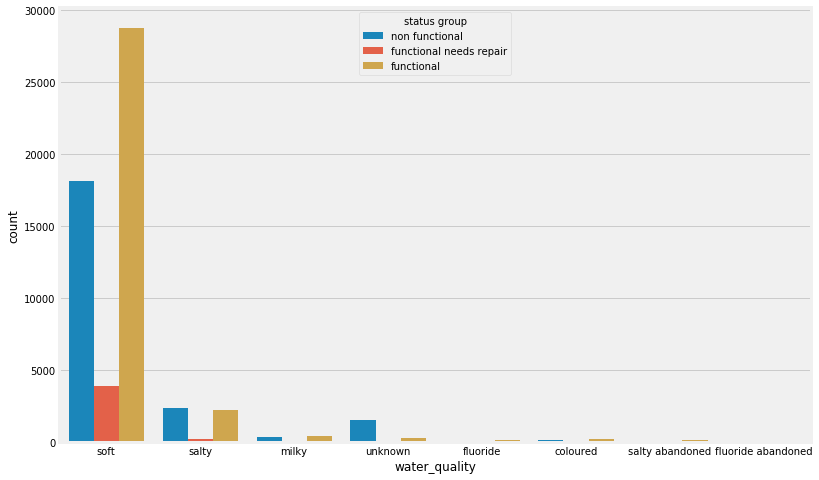

In [26]:
#df.water_quality.value_counts()
plt.rcParams['figure.figsize'] = [12, 8]
g = sns.countplot(x='water_quality',hue='status_group',data=df2);
new_labels = ['non functional','functional needs repair' , 'functional']
plt.legend(title='status group',labels=new_labels);

In [27]:
y = df.status_group.values
df.drop('status_group',axis=1,inplace=True)

In [28]:
#save id column for later
train_ID = df['id']
df.drop('id',axis=1,inplace=True)

In [29]:
#split numerical and categorical features for further processing
numeric_feats = df.dtypes[df.dtypes != "object"].index
cat_feats = df.dtypes[df.dtypes == "object"].index

print("Numerical features : " + str(len(numeric_feats)))
print("Categorical features : " + str(len(cat_feats)))

df_num = df[numeric_feats]
df_cat = df[cat_feats]

Numerical features : 8
Categorical features : 19


In [30]:
#convert to categorical
cat_feats_list = cat_feats.tolist()

for idx in cat_feats_list:
    col_ = pd.Categorical.from_array(df_cat[idx])
    df_cat[idx]= col_.codes

In [31]:
#norm the numeric features - will use trees and or deep learning
#norm = Normalizer()
#df_num.loc[:,numeric_feats] = norm.fit_transform(df_num.loc[:,numeric_feats]) 

#df_num.head()

In [32]:
#scale the numeric features

In [33]:
df = pd.concat([df_num,df_cat],axis=1)

In [34]:
#df.info()

In [35]:
res = y == 2
res.sum()

32259

In [36]:
# Partition the dataset in train + validation sets
test_size = 0.33
seed = seed
X_train, X_test, y_train, y_test = train_test_split(df.values, y, test_size = test_size, random_state = seed,stratify=y)

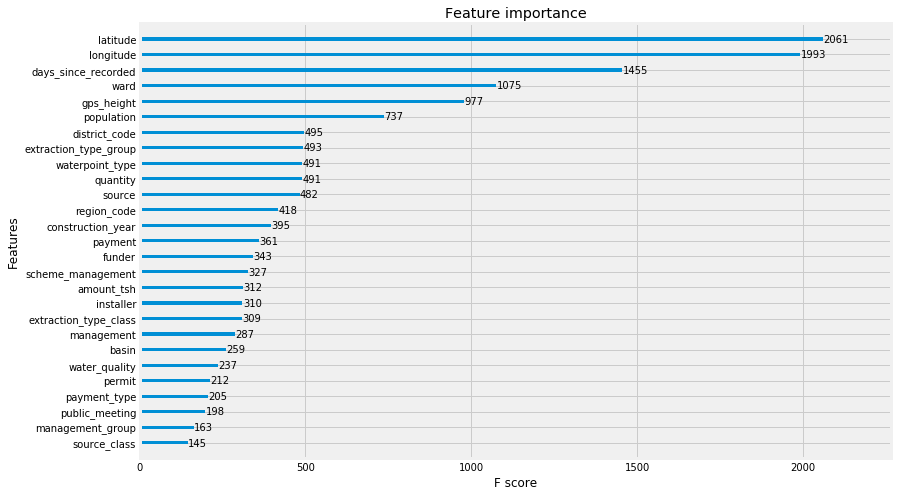

In [37]:
#try xgb for feature importances
water_dmatrix = xgb.DMatrix(data=df, label=y)

# Create the parameter dictionary: params
params = {'learning_rate': 0.1, 'n_estimators': 500, 'seed':42, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'multi:softmax','num_class':3,'silent':1}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=water_dmatrix, num_boost_round=100);

# Plot the feature importances
xgb.plot_importance(xg_reg);
plt.show()

In [38]:
xgdmat = xgb.DMatrix(X_train, y_train) # Create our DMatrix to make XGBoost more efficient

In [39]:
#our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
#             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
#params = {'learning_rate': 0.1, 'n_estimators': 500, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
#             'objective': 'multi:softmax','num_class':3}
# Grid Search CV optimized settings

#cv_xgb = xgb.cv(params = params, dtrain = xgdmat, num_boost_round = 200, nfold = 5,
#                metrics = ['mlogloss'], # Make sure you enter metrics inside a list or you may encounter issues!
#                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [40]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [41]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective': 'multi:softmax',
    'num_class':3,
    'silent':1,
    'eval_metric':'mlogloss'
    
}
#params['silent'] = 1

In [42]:
#params['eval_metric'] = "mlogloss"

In [43]:
num_boost_round = 999

In [44]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    verbose_eval=False
)

In [45]:
#Stopping. Best iteration:
#[433]	Test-mlogloss:0.349658

In [46]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=seed,
    nfold=5,
    metrics={'mlogloss'},
    early_stopping_rounds=10,
    verbose_eval=False
)

In [47]:
cv_results['test-mlogloss-mean'].min()

0.5054734

In [48]:
cv_results.tail()

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
144,0.505634,0.005191,0.330373,0.002406
145,0.505623,0.005216,0.329400,0.002309
146,0.505508,0.005339,0.328531,0.002180
147,0.505494,0.005376,0.327701,0.002019
148,0.505473,0.005349,0.326669,0.002057


### Parameters max_depth and min_child_weight
Those parameters add constraints on the architecture of the trees.

- *max_depth* is the maximum number of nodes allowed from the root to the farthest leaf of a tree. Deeper trees can model more complex relationships by adding more nodes, but as we go deeper, splits become less relevant and are sometimes only due to noise, causing the model to overfit.
- *min_child_weight* is the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit.

Thus, those parameters can be used to control the complexity of the trees. It is important to tune them together in order to find a good trade-off between model bias and variance

In [49]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in (10,15,20)
    for min_child_weight in (5,10,15)
]

In [50]:
gridsearch_params

[(10, 5),
 (10, 10),
 (10, 15),
 (15, 5),
 (15, 10),
 (15, 15),
 (20, 5),
 (20, 10),
 (20, 15)]

In [51]:
# Define initial best params and logloss
min_logloss = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth,min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight   
    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=seed,
        nfold=5,
        metrics={'mlogloss'},
        early_stopping_rounds=10,
        verbose_eval=False
    )
    # Update best logloss
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds".format(mean_mlogloss, boost_rounds))
    if mean_mlogloss < min_logloss:
        min_logloss = mean_mlogloss
        best_params = (max_depth,min_child_weight)
        
print("Best params: {}, {}, mlogloss: {}".format(best_params[0], best_params[1], min_logloss))
cv_results.tail()

CV with max_depth=10, min_child_weight=5
	mlogloss 0.49779239999999997 for 63 rounds
CV with max_depth=10, min_child_weight=10
	mlogloss 0.4973318 for 72 rounds
CV with max_depth=10, min_child_weight=15
	mlogloss 0.49705639999999995 for 78 rounds
CV with max_depth=15, min_child_weight=5
	mlogloss 0.49888960000000004 for 24 rounds
CV with max_depth=15, min_child_weight=10
	mlogloss 0.4956408 for 32 rounds
CV with max_depth=15, min_child_weight=15
	mlogloss 0.4966908 for 45 rounds
CV with max_depth=20, min_child_weight=5
	mlogloss 0.503247 for 17 rounds
CV with max_depth=20, min_child_weight=10
	mlogloss 0.4970682 for 22 rounds
CV with max_depth=20, min_child_weight=15
	mlogloss 0.49752219999999997 for 30 rounds
Best params: 15, 10, mlogloss: 0.4956408


,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
26,0.498015,0.006047,0.304728,0.002411
27,0.498096,0.006006,0.301932,0.002710
28,0.497775,0.005949,0.298754,0.003022
29,0.497626,0.006069,0.295972,0.003045
30,0.497522,0.006225,0.293463,0.002711


In [52]:
params['max_depth'] = 15
params['min_child_weight'] = 10

### Parameters subsample and colsample_bytree
Those parameters control the sampling of the dataset that is done at each boosting round.

Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature.

- *subsample* corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.
- *colsample_bytree* corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features.

Let’s see if we can get better results by tuning those parameters together.

In [53]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [54]:
# Define initial best params and loss
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(subsample,colsample))
    
     # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample  
    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mlogloss'},
        early_stopping_rounds=10,
        verbose_eval=False
    )
    # Update best logloss
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds".format(mean_mlogloss, boost_rounds))
    if mean_mlogloss < min_logloss:
        min_logloss = mean_mlogloss
        best_params = (subsample,colsample)

print("Best params: {}, {}, mlogloss: {}".format(best_params[0], best_params[1], min_logloss))


CV with subsample=1.0, colsample=1.0
	mlogloss 0.4956408 for 32 rounds
CV with subsample=1.0, colsample=0.9
	mlogloss 0.4950042 for 34 rounds
CV with subsample=1.0, colsample=0.8
	mlogloss 0.49373199999999995 for 33 rounds
CV with subsample=1.0, colsample=0.7
	mlogloss 0.49057680000000004 for 33 rounds
CV with subsample=0.9, colsample=1.0
	mlogloss 0.4966742 for 27 rounds
CV with subsample=0.9, colsample=0.9
	mlogloss 0.4954024 for 33 rounds
CV with subsample=0.9, colsample=0.8
	mlogloss 0.49413819999999997 for 33 rounds
CV with subsample=0.9, colsample=0.7
	mlogloss 0.4950996 for 34 rounds
CV with subsample=0.8, colsample=1.0
	mlogloss 0.49766379999999993 for 27 rounds
CV with subsample=0.8, colsample=0.9
	mlogloss 0.4958212000000001 for 33 rounds
CV with subsample=0.8, colsample=0.8
	mlogloss 0.49614079999999994 for 36 rounds
CV with subsample=0.8, colsample=0.7
	mlogloss 0.49429920000000005 for 34 rounds
CV with subsample=0.7, colsample=1.0
	mlogloss 0.49904460000000006 for 35 round

In [55]:
params['subsample'] = 1.
params['colsample_bytree'] = 0.7

### Parameter ETA
The ETA parameter controls the learning rate. It corresponds to the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step

In [56]:
params['eta'] = 0.1

In [57]:
params

{'max_depth': 15,
 'min_child_weight': 10,
 'eta': 0.1,
 'subsample': 1.0,
 'colsample_bytree': 0.7,
 'objective': 'multi:softmax',
 'num_class': 3,
 'silent': 1,
 'eval_metric': 'mlogloss'}

In [58]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    verbose_eval=False
)

In [59]:
print("Best logloss: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best logloss: 0.47 in 126 rounds


In [60]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    verbose_eval=False
)

In [61]:
print(sum(best_model.predict(dtest)==0))
print(sum(best_model.predict(dtest)==1))
print(sum(best_model.predict(dtest)==2))

6971
721
11910


In [62]:
print(sum(y_test == 0))
print(sum(y_test == 1))
print(sum(y_test == 2))

7532
1425
10645


In [64]:
#calculate f1 score 
from sklearn.metrics import f1_score
f1_score(y_test, best_model.predict(dtest), average='micro')  

0.8122640546882971

In [65]:
sum(best_model.predict(dtest) == y_test)/best_model.predict(dtest)
acc = len(y_test[y_test==best_model.predict(dtest)])/len(y_test)
acc

0.8122640546882971

In [66]:
best_model.save_model("my_model.model")

In [67]:
loaded_model = xgb.Booster()
loaded_model.load_model("my_model.model")
# And use it for predictions.
loaded_model.predict(dtest)

array([0., 0., 2., ..., 2., 2., 1.], dtype=float32)